# Evaluation

The algorithm is evaluated jointly (tracking+segmentation). The segmentation mask is taken as a fixed input (the evaluation of the CNN only is done in another section). The metrics are MOTA and F-score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from skimage import measure
from scipy.optimize import linear_sum_assignment

### Functions for tracking

In [ ]:
def extract_footprints(img, show):
  contours = measure.find_contours(img, 0.8)

  if show == True:
    fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
    ax.imshow(img, cmap=plt.cm.gray)

    for contour in contours:
      ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
  return contours

def isolate_footprints(contour1, contour2):
  x1 = contour1[:,1]
  y1 = contour1[:,0]

  x2 = contour2[:,1]
  y2 = contour2[:,0]

  min_x = min(np.min(x1), np.min(x2))
  min_y = min(np.min(y1), np.min(y2))

  x1 = x1-min_x
  y1 = y1-min_y

  x2 = x2-min_x
  y2 = y2-min_y

  max_x = max(np.max(x1), np.max(x2))
  max_y = max(np.max(y1), np.max(y2))

  reg_shape = (np.ceil(max_x).astype('int'), np.ceil(max_y).astype('int'))

  polygon1 = list(zip(x1, y1))
  polygon2 = list(zip(x2, y2))

  img_out1 = Image.new('L', reg_shape, 0)
  ImageDraw.Draw(img_out1).polygon(polygon1, outline=1, fill=1) #outline=0
  mask1 = np.array(img_out1)

  img_out2 = Image.new('L', reg_shape, 0)
  ImageDraw.Draw(img_out2).polygon(polygon2, outline=1, fill=1) #outline=0
  mask2 = np.array(img_out2)
  
  return mask1, mask2

def compute_iou(mask1, mask2):

  epsilon = 1e-6

  intersection = np.sum(mask1 & mask2)
  # To avoid more computations
  if intersection == 0:
    return 0

  union = np.sum(mask1 | mask2)
    
  iou = (intersection + epsilon) / (union + epsilon)
  return iou 


def in_neighborhood(contour1, contour2, img_shape, area):
  
  xmax1 = min(np.max(contour1[:,1])+area, img_shape[1])
  xmin1 = max(np.min(contour1[:,1])-area, 0)
  ymax1 = min(np.max(contour1[:,0])+area, img_shape[0])
  ymin1 = max(np.min(contour1[:,0])-area, 0)

  xmax2 = min(np.max(contour2[:,1])+area, img_shape[1])
  xmin2 = max(np.min(contour2[:,1])-area, 0)
  ymax2 = min(np.max(contour2[:,0])+area, img_shape[0])
  ymin2 = max(np.min(contour2[:,0])-area, 0)
  

  R1 = [xmin1, ymax1, xmax1, ymin1]
  R2 = [xmin2, ymax2, xmax2, ymin2]
  
  if (R1[0]>=R2[2]) or (R1[2]<=R2[0]) or (R1[3]>=R2[1]) or (R1[1]<=R2[3]):
    return False
  else:
    return True

def compute_costmat(contours1, contours2, region1, region2):
  iou_mat = np.zeros((len(contours1), len(contours2)))
  for idx0, contour_0 in enumerate(contours1):
    for idx1, contour_1 in enumerate(contours2):
      if in_neighborhood(contour_0, contour_1, region1.shape, area=0):
        mask_0, mask_1 = isolate_footprints(contour_0, contour_1)
        iou_mat[idx0,idx1] = compute_iou(mask_0, mask_1)
      
  cost_mat = np.ones((len(contours1), len(contours2))) - iou_mat
  return cost_mat

def propagate_labels(labels, labels_old, len_new):
  #Assign ids old to new detections (-1) if there's no correspondence
  id_new = np.zeros((len_new))  
  for i in range(len(id_new)):
    try:
      id_new[i] = labels_old[np.where(labels == i)[0][0]]
    except:
      id_new[i] = -1
  
  # Assign new id to those detections that don't have correspondence
  count = len(labels_old)
  for idx, i in enumerate(id_new):
    if i == -1:
      id_new[idx] = count
      count += 1
  
  return id_new

def plot_tracking(contours, labels, region, fig_size):
  fig, ax = plt.subplots(figsize=fig_size, dpi=80)
  ax.imshow(region, cmap=plt.cm.gray)

  for i, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax.text(contour[0, 1], contour[0, 0], str(round(labels[i])),verticalalignment='top', color='red',fontsize=10,weight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

In [ ]:
def track_buildings(img_0, img_1, labels_old, fig_size):
  conts_pred0 = extract_footprints(img_0, False)
  conts_pred1 = extract_footprints(img_1, False)
  cost_mat = compute_costmat(conts_pred0, conts_pred1, img_0, img_1)
  _, index = linear_sum_assignment(cost_mat)

  # First time step
  if labels_old is None:
    labels_old = np.arange(len(conts_pred0))
    plot_tracking(conts_pred0, labels_old, img_0, fig_size)

  labels_new = propagate_labels(index, labels_old, len(conts_pred1))
  plot_tracking(conts_pred1, labels_new, img_1, fig_size)

  return labels_old, conts_pred0, labels_new, conts_pred1

### Functions for evaluation 

In [ ]:
def group_contours(labels, contours):
  pairs = {}
  keys = list(labels)
  values = list(contours)
  for key in keys:
    for value in values:
        pairs[key] = value
        values.remove(value)
        break
  return pairs 

def evaluate_tracking(pairs1, pairs2):
  corrects = 0
  for key in pairs1:
    mask1, mask2 = isolate_footprints(pairs1[key], pairs2[key])
    iou = compute_iou(mask1, mask2)
    if iou > 0.5:
      corrects+=1
  
  metric = corrects / len(pairs1)
  return metric 

### Read the ground truth, plot it and generate its labels

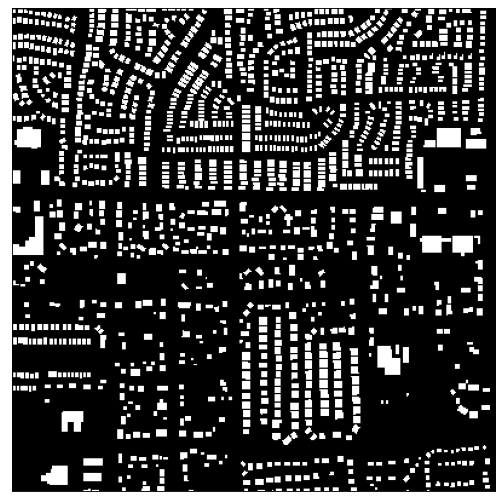

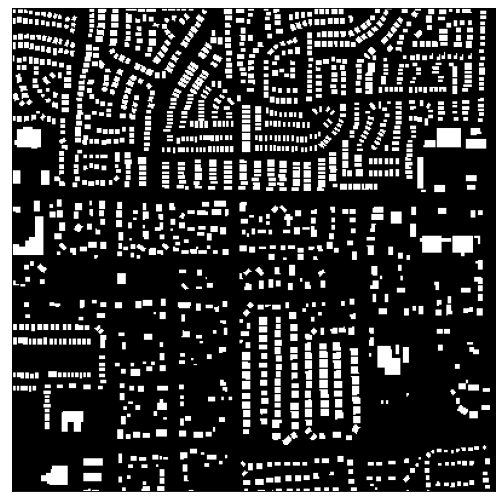

In [ ]:
img_true0 = Image.open('/content/true_m1.png')
r_true0 = np.array(img_true0)
#r_true0 = r_true0[580:680,750:850,0]
r_true0 = r_true0[0:400,0:400,0]
r_true0 = np.where(r_true0>100, 255, 0)

img_true1 = Image.open('/content/true_m2.png')
r_true1 = np.array(img_true1)
#r_true1 = r_true1[580:680,750:850,0]
r_true1 = r_true1[0:400,0:400,0]
r_true1 = np.where(r_true1>100, 255, 0)

fig, ax = plt.subplots(figsize=(8,8), dpi=80)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(r_true0, cmap=plt.cm.gray)

fig, ax = plt.subplots(figsize=(8,8), dpi=80)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(r_true1, cmap=plt.cm.gray)

Generate labels for ground truth

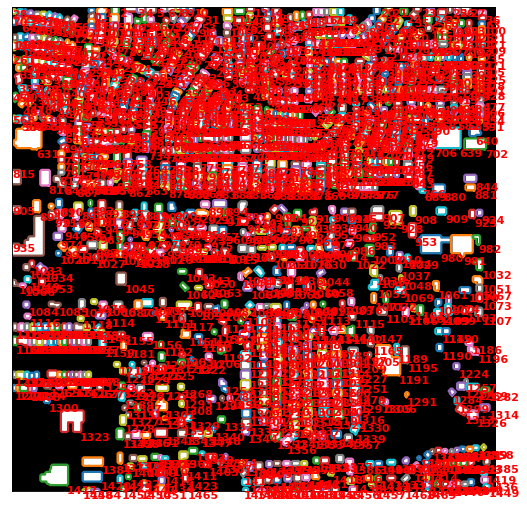

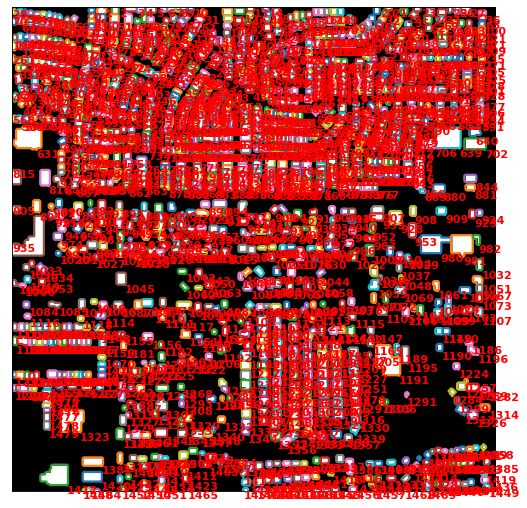

1.0


In [ ]:
labels_true0, conts_true0, labels_true1, conts_true1 = track_buildings(r_true0, r_true1, None, fig_size=(8,8))
pairs_true0 = group_contours(labels_true0, conts_true0)
pairs_true1 = group_contours(labels_true1, conts_true1)

### Apply tracking to the segmentation.
 It will generate the predicted labels

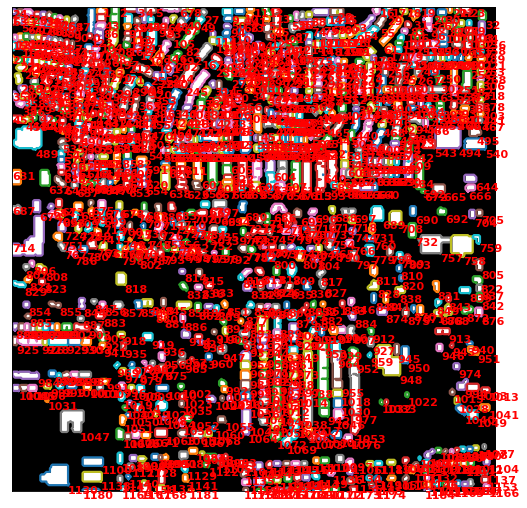

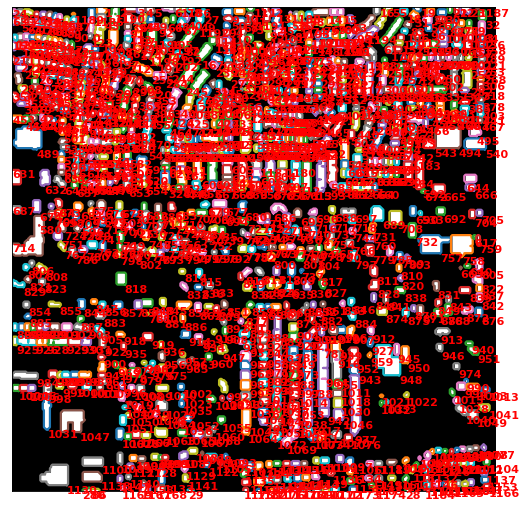

In [ ]:
img_pred0 = Image.open('/content/pred_m1.png')
r_pred0 = np.array(img_pred0)
r_pred0 = r_pred0[0:400,0:400,0]

img_pred1 = Image.open('/content/pred_m2.png')
r_pred1 = np.array(img_pred1)
r_pred1 = r_pred1[0:400,0:400,0]

labels_old, conts_pred0, labels_new, conts_pred1 = track_buildings(r_pred0, r_pred1, None, fig_size=(8,8))

Evaluate Tracking only

In [ ]:
pairs_pred0 = group_contours(labels_old, conts_pred0)
pairs_pred1 = group_contours(labels_new, conts_pred1)

score = evaluate_tracking(pairs_pred0, pairs_pred1)
print(score)

0.9493670886075949


### Joint Evaluation

Evaluate with MOTA

In [ ]:
# MOTA = 1 - (FN+FP+MISSMATCHES)/GT
# FN+FP+MISSMATCHES = ERRORES

def eval_matching(pairs_true, pairs_pred, region):
  fn = 0
  fp = 0
  tp = 0

  for idx_t in pairs_true:
    match = 0 #Restarted for each diff building
    for idx_p in pairs_pred:
      if in_neighborhood(pairs_true[idx_t], pairs_pred[idx_p], region.shape, area=0):
        mask_t, mask_p = isolate_footprints(pairs_true[idx_t], pairs_pred[idx_p])
        iou = compute_iou(mask_t, mask_p)

        if iou > 0.5:  # If there is a match
          match += 1 
          tp += 1 
          break #Since there was a match, continue with next building
      
    if match == 0: #If no match for this building, false negative
      #print(idx_t)
      fn += 1

  for idx_p in pairs_pred:
    match = 0 
    for idx_t in pairs_true:
      if in_neighborhood(pairs_true[idx_t], pairs_pred[idx_p], region.shape, area=0):
        mask_t, mask_p = isolate_footprints(pairs_true[idx_t], pairs_pred[idx_p])
        iou = compute_iou(mask_t, mask_p)

        if iou > 0.5:
          match += 1
          break
  
    if match == 0:
      fp +=1

  return fp, fn, tp

def eval_missmatches(pairs0, pairs1, region):
  mm = 0
  for idx_0 in pairs0:
    for idx_1 in pairs1:
      if in_neighborhood(pairs0[idx_0], pairs1[idx_1], region.shape, area=0):
        mask_t, mask_p = isolate_footprints(pairs0[idx_0], pairs1[idx_1])
        iou = compute_iou(mask_t, mask_p)

        if iou > 0.5:
          if idx_0 != idx_1: #If IDs match then is missmatch
            mm +=1
          break
  return mm

fp0, fn0, tp0 = eval_matching(pairs_true0, pairs_pred0, r_pred0)
fp1, fn1, tp1 = eval_matching(pairs_true1, pairs_pred1, r_pred1)
missmatches = eval_missmatches(pairs_pred0, pairs_pred1, r_pred0)

errors = fp0+fp1+fn0+fn1+missmatches
gt = len(pairs_true0)+len(pairs_true1)
MOTA = 1 - (errors/gt)
print ('MOTA', MOTA)

MOTA 0.6477966101694915


Evaluate with F-score

In [ ]:
fp = fp0+fp1
fn = fn0+fn1
tp = tp0+tp1

fscore = tp/(tp+(1/2)*(fn+fp))
print(fscore)

0.8059757236227825
